In [1]:
import tensorflow as tf
from __future__ import division, print_function, absolute_import
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from ops import *

C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\frame

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
fmnist = input_data.read_data_sets('data/fashion', source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [59]:
np.random.seed(134) 
tf.set_random_seed(34)

In [9]:
num_steps=150000 #No of times generator/discriminator is updated before it moves onto discriminator/generator?
learning_rate=0.0002
batch_size=128 #So that you don't have to load all your data at once
beta1=0.5
#Network Parameters
z_dim=100
c_dim=1
input_height = 28
input_width = 28
output_height = 28
output_width = 28
image_dims = [input_height, input_width, c_dim]

#Initializing the weight parameters:
# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

drop_out_rate=tf.placeholder(tf.float32)
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

In [10]:
def generator(z, is_training=True, reuse=False):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    with tf.variable_scope("generator", reuse=reuse):
        net = tf.nn.relu(bn(linear(z, 1024, scope='g_fc1'), is_training=is_training, scope='g_bn1'))
        net = tf.nn.relu(bn(linear(net, 128 * 7 * 7, scope='g_fc2'), is_training=is_training, scope='g_bn2'))
        net = tf.reshape(net, [batch_size, 7, 7, 128])
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, 14, 14, 64], 4, 4, 2, 2, name='g_dc3'), is_training=is_training,
               scope='g_bn3'))
        out = tf.nn.sigmoid(deconv2d(net, [batch_size, 28, 28, 1], 4, 4, 2, 2, name='g_dc4'))
        return out    

In [11]:
def discriminator(x, is_training=True, reuse=False):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    with tf.variable_scope("discriminator", reuse=reuse):
        net = lrelu(conv2d(x, 64, 4, 4, 2, 2, name='d_conv1'))
        net = lrelu(bn(conv2d(net, 128, 4, 4, 2, 2, name='d_conv2'), is_training=is_training, scope='d_bn2'))
        net = tf.reshape(net, [batch_size, -1])
        net = lrelu(bn(linear(net, 1024, scope='d_fc3'), is_training=is_training, scope='d_bn3'))
        out_logit = linear(net, 1, scope='d_fc4')
        out = tf.nn.sigmoid(out_logit)
        return out, out_logit, net

In [16]:
inputs = tf.placeholder(tf.float32, [batch_size] + image_dims, name='real_images')
z = tf.placeholder(tf.float32, [batch_size, z_dim], name='z')

def build_model():
    # output of D for real images
    D_real, D_real_logits, _ = discriminator(inputs, is_training=True, reuse=False)

    # output of D for fake images
    G =generator(z, is_training=True, reuse=False)
    D_fake, D_fake_logits, _ = discriminator(G, is_training=True, reuse=True)

    # get loss for discriminator
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake)))

    d_loss = d_loss_real + d_loss_fake

    # get loss for generator
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake)))

    # divide trainable variables into a group for D and a group for G
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'd_' in var.name]
    g_vars = [var for var in t_vars if 'g_' in var.name]

    # optimizers
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1) \
                  .minimize(self.d_loss, var_list=d_vars)
        g_optim = tf.train.AdamOptimizer(learning_rate*5, beta1=beta1) \
                  .minimize(self.g_loss, var_list=g_vars)


       

In [65]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

Step 0: Generator Loss: 20.298277, Discriminator Loss: 12.566673


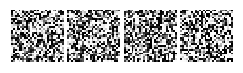

Step 1: Generator Loss: 19.732769, Discriminator Loss: 11.705145


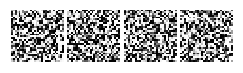

Step 4000: Generator Loss: 3.131590, Discriminator Loss: 0.691219


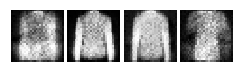

Step 8000: Generator Loss: 2.717524, Discriminator Loss: 0.890187


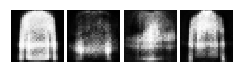

Step 12000: Generator Loss: 2.405822, Discriminator Loss: 0.975423


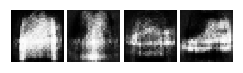

Step 16000: Generator Loss: 2.184928, Discriminator Loss: 1.056045


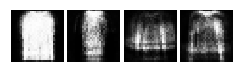

Step 20000: Generator Loss: 2.517419, Discriminator Loss: 0.991011


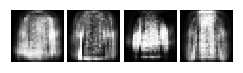

Step 24000: Generator Loss: 2.375185, Discriminator Loss: 1.069222


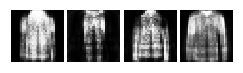

Step 28000: Generator Loss: 2.112729, Discriminator Loss: 0.968914


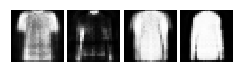

Step 32000: Generator Loss: 2.129636, Discriminator Loss: 1.123923


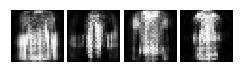

Step 36000: Generator Loss: 2.571547, Discriminator Loss: 0.863336


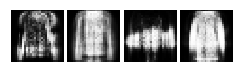

Step 40000: Generator Loss: 1.890723, Discriminator Loss: 1.036727


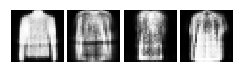

Step 44000: Generator Loss: 1.910304, Discriminator Loss: 1.069951


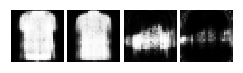

Step 48000: Generator Loss: 2.103935, Discriminator Loss: 1.136420


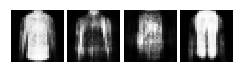

Step 52000: Generator Loss: 2.246051, Discriminator Loss: 0.924154


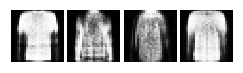

Step 56000: Generator Loss: 2.473513, Discriminator Loss: 0.981065


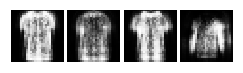

Step 60000: Generator Loss: 2.096488, Discriminator Loss: 0.952925


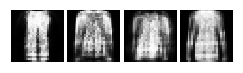

Step 64000: Generator Loss: 2.318273, Discriminator Loss: 0.920564


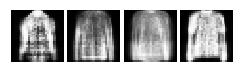

Step 68000: Generator Loss: 2.219188, Discriminator Loss: 0.945641


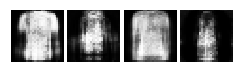

Step 72000: Generator Loss: 2.152502, Discriminator Loss: 1.073669


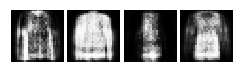

Step 76000: Generator Loss: 1.992832, Discriminator Loss: 1.173831


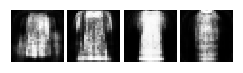

Step 80000: Generator Loss: 2.036703, Discriminator Loss: 1.072857


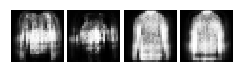

Step 84000: Generator Loss: 2.098300, Discriminator Loss: 0.986563


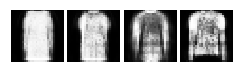

Step 88000: Generator Loss: 2.269839, Discriminator Loss: 1.008997


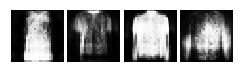

Step 92000: Generator Loss: 2.297194, Discriminator Loss: 0.860481


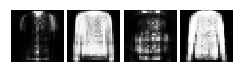

Step 96000: Generator Loss: 2.100679, Discriminator Loss: 1.037623


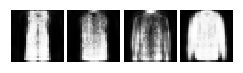

Step 100000: Generator Loss: 2.322914, Discriminator Loss: 0.872088


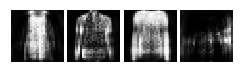

Step 104000: Generator Loss: 1.952736, Discriminator Loss: 1.162814


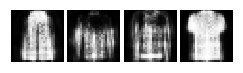

Step 108000: Generator Loss: 2.394320, Discriminator Loss: 0.966236


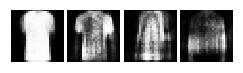

Step 112000: Generator Loss: 1.883995, Discriminator Loss: 1.112356


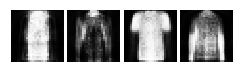

Step 116000: Generator Loss: 1.998317, Discriminator Loss: 0.957007


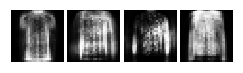

Step 120000: Generator Loss: 2.095694, Discriminator Loss: 0.992874


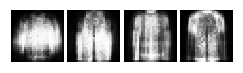

Step 124000: Generator Loss: 2.004184, Discriminator Loss: 1.055191


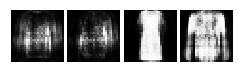

Step 128000: Generator Loss: 2.091570, Discriminator Loss: 1.124893


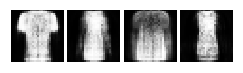

Step 132000: Generator Loss: 1.946483, Discriminator Loss: 1.007952


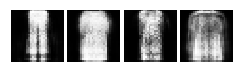

Step 136000: Generator Loss: 2.136162, Discriminator Loss: 0.972891


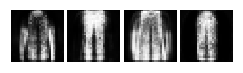

Step 140000: Generator Loss: 1.730366, Discriminator Loss: 1.113672


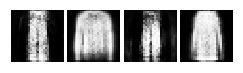

Step 144000: Generator Loss: 1.767371, Discriminator Loss: 1.121554


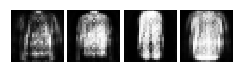

Step 148000: Generator Loss: 2.082526, Discriminator Loss: 1.052110


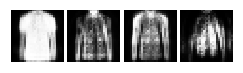

In [66]:
config = tf.ConfigProto(device_count = {'GPU': 1})
sess = tf.Session(config=config)

#with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
sess.run(init)
for i in range(num_steps):
    batch_x, _ = fmnist.train.next_batch(batch_size)
    batch_x = batch_x * 2. - 1.
    z = np.random.normal(0., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={gen_input:z, drop_out_rate:0.5})
    _, dl = sess.run([train_dis, disc_loss], feed_dict={disc_input: batch_x, gen_input:z, drop_out_rate:0.5})
    
    if i % 4000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        z=np.random.normal(0, 1., size=[4, noise_dim])
        samples = sess.run(gen_sample, feed_dict={gen_input: z,drop_out_rate:0.5})
        fig = plot(samples)
        plt.show()

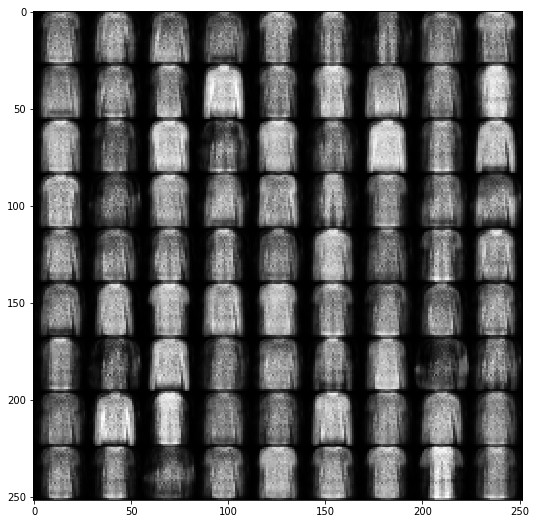

In [67]:
n = 9
averaging_over=20
arr=[]
canvas = np.empty((28 * n, 28 * n))
canvas1 = np.empty((averaging_over,28 * n, 28 * n))

for i in range(n):
    arr=[]
    z = np.random.normal(0, 1., size=[n, noise_dim])
    g = sess.run(gen_sample, feed_dict={gen_input: z,drop_out_rate:0.5})
    g = (g + 1.) / 2.
    for j in range(averaging_over):
        f = sess.run(gen_sample, feed_dict={gen_input: z,drop_out_rate:0.5})
        f = (f + 1.) / 2.
        arr.append(f)
        g+= f
    g=g/11
    for j in range(n):
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28]) 

    for k in range(averaging_over):
        a=arr[k]
        for j in range(n):
            canvas1[k,i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = a[j].reshape([28, 28])    
            
plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.imsave('fmnist_mc_dropout_w15.png',canvas,cmap="gray")

for k in range(averaging_over):
    plt.imsave('fmnist_mc_dropout_{}5.png'.format(k),canvas1[k],cmap="gray")

plt.show()

In [68]:
sess.close()